We will set everything up and see if we can learn a but be in truth the mlp should not do well in the general case

In [250]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay, classification_report


from combined_data_script import get_data
from medication_data_script import LeakageOption


In [ ]:
data_dic = get_data(flatten=True,leakage_option=LeakageOption.FULL_LEAKAGE, stride=5)

In [252]:
train, dev, test = data_dic['train'], data_dic['dev'], data_dic['test'] 

In [253]:
len(train) #note it is NOT shuffled we will nedd to do this

10426

In [254]:
#important that we shuffle THEY ARE NOT IF WE DONT
torch.manual_seed(69)
train_loader = DataLoader(train, batch_size=1024, shuffle=True)
dev_loader = DataLoader(dev, batch_size=1024, shuffle=True)

In [255]:
class simple_mlp(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.l0 = nn.Linear(2400, 2048)
        self.l1 = nn.Linear(2048,512)
        self.out = nn.Linear(512, 1)

    def forward(self, X):
        x = self.l0(X)
        x = self.l1(x)
        x = self.out(x)
        return x

model = simple_mlp()

In [256]:
device = "mps"
model = model.to(device)

In [257]:
criterion = nn.BCEWithLogitsLoss()
optimizer =  torch.optim.Adam(model.parameters(), lr=0.001)

In [258]:
lossi = []
devlossi = []

In [259]:
for epoch in tqdm(range(10)):
    loss_total = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device) 

        logits = model(X_batch)
        loss = criterion(logits, y_batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item()

    lossi.append(loss_total / len(train_loader))

    with torch.no_grad():
        dev_loss_total = 0
        for X_dev, y_dev in dev_loader:
            X_dev, y_dev = X_dev.to(device), y_dev.to(device) 

            dev_logits = model(X_dev)
            dev_loss = criterion(dev_logits, y_dev.float())
            dev_loss_total += dev_loss.item()

    devlossi.append(dev_loss_total / len(dev_loader))
        

100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


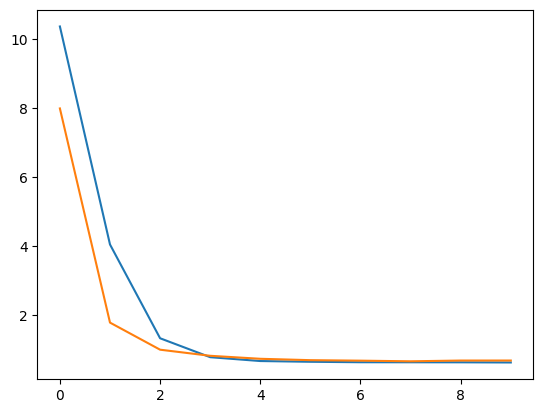

In [260]:
plt.plot(lossi)
plt.plot(devlossi)

In [261]:
preds = dev_logits.cpu()
preds = (preds > 0.5).float()

In [262]:
print(classification_report(y_dev.cpu().numpy(), preds))

              precision    recall  f1-score   support

           0       0.48      0.83      0.61       143
           1       0.19      0.04      0.07       135

    accuracy                           0.45       278
   macro avg       0.34      0.43      0.34       278
weighted avg       0.34      0.45      0.35       278



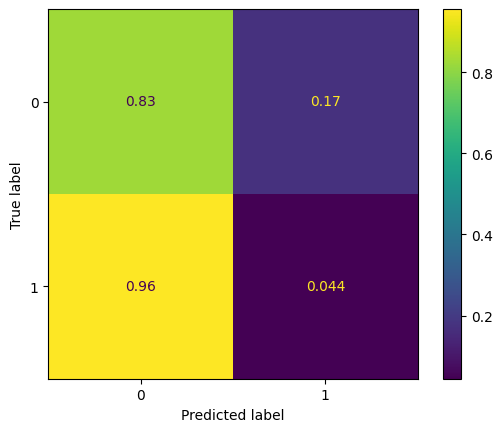

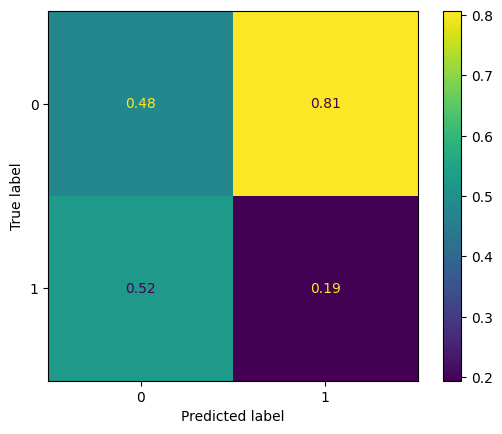

In [263]:
ConfusionMatrixDisplay.from_predictions(y_dev.cpu().numpy(), preds, normalize='true')
ConfusionMatrixDisplay.from_predictions(y_dev.cpu().numpy(), preds, normalize='pred')

So it doesnt do well actualy it suck be that good we doen expect it to. but we know that we have other parts working

____

We now say can we overfit on one batch?


In [264]:
X_overfit, y_overfit = next(iter(train_loader))
X_overfit.shape, y_overfit.shape

(torch.Size([1024, 2400]), torch.Size([1024, 1]))

In [265]:
model = simple_mlp()
optimizer =  torch.optim.Adam(model.parameters(), lr=0.00001)

In [266]:
lossi = []

In [267]:
for epoch in range(250):
    logits = model(X_overfit)
    loss = criterion(logits, y_overfit.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lossi.append(loss.item())

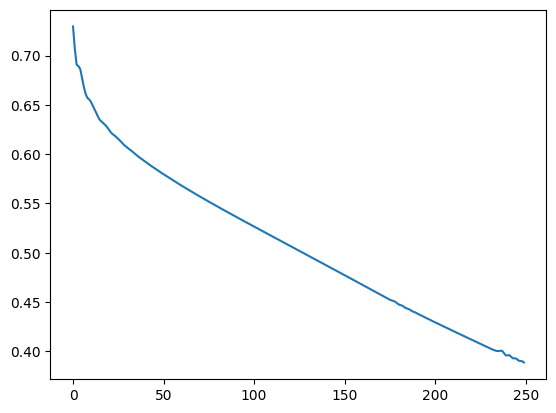

In [268]:
plt.plot(lossi)

In [269]:
preds = logits.cpu()
preds = (preds > 0.5).float()
print(classification_report(y_overfit.cpu().numpy(), preds))

              precision    recall  f1-score   support

           0       0.73      0.94      0.82       532
           1       0.91      0.62      0.74       492

    accuracy                           0.79      1024
   macro avg       0.82      0.78      0.78      1024
weighted avg       0.82      0.79      0.78      1024



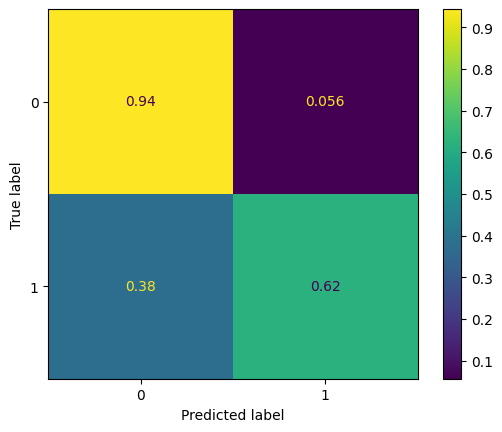

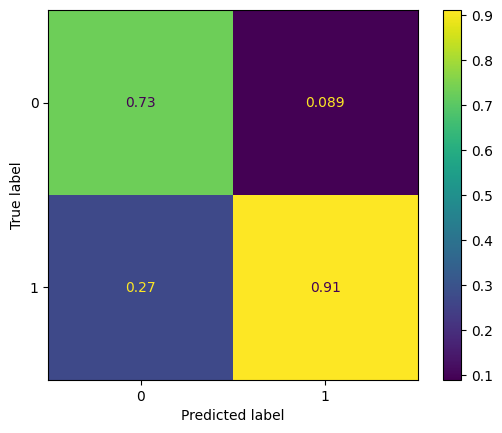

In [270]:
ConfusionMatrixDisplay.from_predictions(y_overfit.cpu().numpy(), preds, normalize='true')
ConfusionMatrixDisplay.from_predictions(y_overfit.cpu().numpy(), preds, normalize='pred')

Sweet we are able to over fit on one batch now lets make a more robsut model and see how that goes